### Continuity


> Samples are needed for sequence models and transformer models for input

😈 **Task 1:** What are some key differences between AR models and sequence models like RNNs or Transformers?

😈 **Question 1:** Why is it important to maintain time continuity when preparing samples for sequence models?



In [1]:
import pandas as pd
import os

## Normalized data csv is also made available for the select stations in URL:
# https://drive.google.com/file/d/1ohReYdUgtBFogeAmxghPo3_Qa9RnzxSh/view?usp=drive_link
# r".\content\timeseries_data\normalized_data.csv"
dataframes = pd.read_csv(r".\content\timeseries_data\normalized_data.csv")
variable_columns = ["no2", "temp", "o3", "no", "press"]
dataframes.shape

(702894, 9)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

In [3]:
# Function to create time-series data with past 24 hours as input and next 6 hours as output
def create_sequences(data, n_past=24, n_future=6):
    X, y = [], []
    for i in range(n_past, len(data) - n_future):
        X.append(data[i - n_past:i])
        y.append(data[i:i + n_future])
    return np.array(X), np.array(y)

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

80/20 train/test split chosen for illustration

😈 **Task 2:** Try a rolling-window cross-validation strategy. How does model performance vary?

😈 **Question 2:** What are the pitfalls of using random splits in timeseries forecasting?


In [4]:
context_window = 336
prediction_horizon = 96 # Predict 96 steps for each variable from 24 past values
X, y = create_sequences(dataframes[variable_columns].values,context_window,prediction_horizon)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

scaler_stats = {col: {'mean': dataframes[col].mean(), 'std': dataframes[col].std()} for col in variable_columns}

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (561969, 336, 5), y_train shape: (561969, 96, 5)
X_test shape: (140493, 336, 5), y_test shape: (140493, 96, 5)


In [ ]:
import pickle

with open("./content/X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)

with open("./content/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open("./content/y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

with open("./content/y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

print("Train/test datasets saved successfully.")

Train/test datasets saved successfully.


In [1]:
import pickle

with open("./content/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("./content/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("./content/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("./content/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (561969, 336, 5), y_train shape: (561969, 96, 5)
X_test shape: (140493, 336, 5), y_test shape: (140493, 96, 5)


## Check for causality

😈 **Task 3:** Run a Granger test between `temp` and `o3`. Is there any directional causality?

😈 **Question 3:** Why is Granger causality not the same as actual causality?


In [5]:
from statsmodels.tsa.stattools import grangercausalitytests
for col in ["no2", "temp", "no", "press"]:
    print(f"\nTesting if {col} Granger-causes o3:")
    grangercausalitytests(dataframes[['o3', col]], maxlag=4)


Testing if no2 Granger-causes o3:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=281.5780, p=0.0000  , df_denom=702890, df_num=1
ssr based chi2 test:   chi2=281.5792, p=0.0000  , df=1
likelihood ratio test: chi2=281.5228, p=0.0000  , df=1
parameter F test:         F=281.5780, p=0.0000  , df_denom=702890, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=515.6265, p=0.0000  , df_denom=702887, df_num=2
ssr based chi2 test:   chi2=1031.2604, p=0.0000  , df=2
likelihood ratio test: chi2=1030.5046, p=0.0000  , df=2
parameter F test:         F=515.6265, p=0.0000  , df_denom=702887, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=213.7986, p=0.0000  , df_denom=702884, df_num=3
ssr based chi2 test:   chi2=641.4023, p=0.0000  , df=3
likelihood ratio test: chi2=641.1098, p=0.0000  , df=3
parameter F test:         F=213.7986, p=0.0000  , df_denom=702884, df_num=3

Granger Causality
number of lags (no z

### Forecasting with MA models: SARIMAX


😈 **Task 4:** Try modeling without seasonal terms. How do AIC and RMSE compare?

😈 **Task 5:** Add an exogenous variable like `temp` into SARIMAX and observe results.

😈 **Question 4:** How does adding an exogenous variable enhance forecasting in SARIMAX?




Station: DENW094 | ADF p-value: 0.0


c:\Users\s.vasired\miniconda3\envs\myenv_labex\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\s.vasired\miniconda3\envs\myenv_labex\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\s.vasired\miniconda3\envs\myenv_labex\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\s.vasired\miniconda3\envs\myenv_labex\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this metho

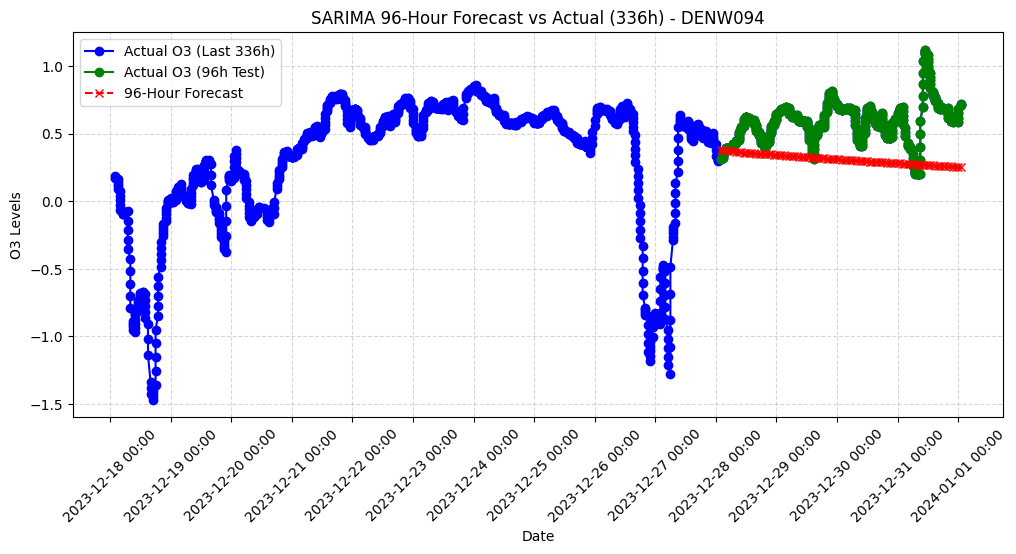

,SARIMA Summary
DENW094,Error: Found input variables with inconsistent...


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error

dataframes['datetime'] = pd.to_datetime(dataframes['datetime'])
df = dataframes.sort_values(by=['station_code', 'datetime'])

# Define forecast horizon (96 hours = 4 days)
forecast_hours = 96

sarima_results = {}

for station in df['station_code'].unique():
    station_data = df[df['station_code'] == station].copy()
    station_data.set_index('datetime', inplace=True)
    station_data = station_data.sort_index()

    # Use only 'o3' column
    o3_data = station_data['o3'].dropna()
    
    if len(o3_data) > 50 + forecast_hours:  # To ensure sufficient data points
        train_o3_data = o3_data.iloc[:-forecast_hours]
        test_o3_data = o3_data.loc[o3_data.index >= (o3_data.index[-1] - pd.Timedelta(hours=95))]
        
        # Check stationarity using ADF test
        adf_test = adfuller(train_o3_data)
        p_value = adf_test[1]
        print(f"Station: {station} | ADF p-value: {p_value}")

        # Differencing if needed
        d = 0 if p_value < 0.05 else 1  # If p-value < 0.05, it's stationary

        # Detect seasonal frequency
        inferred_freq = pd.infer_freq(train_o3_data.index)
        if inferred_freq is not None:
            if "H" in inferred_freq:  
                seasonal_period = 24
            elif "D" in inferred_freq:  
                seasonal_period = 7
            elif "M" in inferred_freq: 
                seasonal_period = 12
            else:
                seasonal_period = 12 
        else:
            seasonal_period = 12  # Default if frequency cannot be inferred

        # Fit SARIMA model
        try:
            sarima_model = SARIMAX(train_o3_data,
                order=(1, d, 1),
                seasonal_order=(1, d, 1, seasonal_period),
                enforce_stationarity=False,
                enforce_invertibility=False).fit()

            fitted_values = sarima_model.fittedvalues
            forecast = sarima_model.get_forecast(steps=forecast_hours)
            forecast_values = forecast.predicted_mean
            confidence_intervals = forecast.conf_int()
            forecast_index = pd.date_range(start=test_o3_data.index[0], periods=forecast_hours, freq="h")
            actual_336 = o3_data.loc[o3_data.index >= (o3_data.index[-1] - pd.Timedelta(hours=335))]

            # Plot actual vs predicted values
            plt.figure(figsize=(12, 5))

            plt.plot(actual_336.index, actual_336, label="Actual O3 (Last 336h)", marker='o', color='blue')
            plt.plot(test_o3_data.index, test_o3_data, label="Actual O3 (96h Test)", marker='o', color='green')
            plt.plot(forecast_index, forecast_values, label="96-Hour Forecast", linestyle="dashed", marker='x', color='red')

            plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
            plt.xticks(rotation=45)

            plt.title(f"SARIMA 96-Hour Forecast vs Actual (336h) - {station}")
            plt.xlabel("Date")
            plt.ylabel("O3 Levels")
            plt.legend()
            plt.grid(True, linestyle="--", alpha=0.5)
            plt.show()

            sarima_results[station] = sarima_model.summary()

            mse = mean_squared_error(test_o3_data, forecast_values)
            print(f"Mean Squared Error (MSE): {mse:.3f}")

        except Exception as e:
            sarima_results[station] = f"Error: {e}"

sarima_results_df = pd.DataFrame.from_dict(sarima_results, orient='index', columns=['SARIMA Summary'])
display(sarima_results_df)
